# Смена директории

In [1]:
%cd ..

/Users/uzumnasiya/Work/RM_UTILS


# Импорт утилит

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

# Данные

In [3]:
# Загружаем датасет про планеты
data = sns.load_dataset('planets')
data.head(7)

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009
5,Radial Velocity,1,185.840,4.80,76.39,2008
6,Radial Velocity,1,1773.400,4.64,18.15,2002


# SQL connectors

In [4]:
from rm_utils.sql.db_connectors import PostgreSQLConnector, ClickSQLConnector

/Users/uzumnasiya/Work/RM_UTILS/.venv/lib/python3.13/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/Users/uzumnasiya/Work/RM_UTILS/.venv/lib/python3.13/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [ ]:
# Укажите данные для подключения
click_creds = {
    'username': '',
    'password': '',
    'ssh_pkey': '' # Путь до ключа SSH
}

postgre_creds = {
    'username': '',
    'password': ''
}

# Создаем экземпляры коннекторов
click_db_conn = ClickSQLConnector(click_creds)
postgre_db_conn = PostgreSQLConnector(postgre_creds)

In [6]:
# Тест подключения
click_db_conn.connection_test()

True

In [7]:
# Загрузка датафрейма в БД
click_db_conn.dataframe_to_sql(
    data=data,
    schema='sandbox',
    table_name='planets',
    batch_size=20_000,
    if_exists='drop'
)

Предупреждение: неизвестные типы {'str'}, будут преобразованы в String
Загружается батч 1, строк: 1035


In [8]:
# Выполнение множественных запросов
sql = """
drop table if exists sandbox.heavy_planets;
create table         sandbox.heavy_planets engine = MergeTree order by tuple() as 

    select * from sandbox.planets where mass > 10
    
"""

click_db_conn.execute_multiple_query(sql)

In [9]:
# Загрузка датафрейма из БД
sql = """select * from sandbox.heavy_planets"""
data_from_sql = click_db_conn.dataframe_from_sql(sql)


print(f'{data_from_sql.shape = }')
data_from_sql.head(4)

data_from_sql.shape = (30, 6)


,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,326.03,19.4,110.62,2007
1,Radial Velocity,1,516.22,10.5,119.47,2009
2,Radial Velocity,1,993.30,10.3,73.10,2008
3,Radial Velocity,1,305.50,20.6,92.51,2013


# Metric Calculator

In [4]:
from rm_utils.metrics import MetricCalculator, metric_funcs

In [5]:
# Проставляем фиктивные предсказания
data['preds'] = 100

In [6]:
metr_funcs = {
    'mape': metric_funcs.mean_absolute_percentage_error,
    'short': metric_funcs.shortfall,
    'rmse': metric_funcs.root_mse,
    'mean_pred': lambda y_true, pred: np.mean(pred)
}

stats_funcs = {
    'mean_targ': lambda y_true, data: np.mean(y_true),
    'n_obs_targ': lambda y_true, data: len(y_true)
}

# Инициализируем калькулятор метрик
metr_calc = MetricCalculator(metr_funcs=metr_funcs, stats_funcs=stats_funcs)

In [7]:
# Считаем метрики
metr_split = metr_calc.calculate(
    data=data.loc[data["distance"].notna()],  # Датафрейм
    true_col="distance",  # Таргет
    pred_cols="preds",  # Предсказания
    group_cols="year",  # Столбец/ы для группировки
)

metr_split

,year,pred,mape,short,rmse,mean_pred,mean_targ,n_obs_targ
0,1989,preds,1.464876,-1.464876,3.531925e+03,100.0,40.570000,1
1,1995,preds,5.510417,-5.510417,7.163930e+03,100.0,15.360000,1
2,1996,preds,5.518301,-5.302521,7.087735e+03,100.0,15.866667,6
3,1997,preds,4.737235,-4.737235,6.817805e+03,100.0,17.430000,1
4,1998,preds,6.154271,-2.801992,5.658691e+03,100.0,26.302000,5
5,1999,preds,3.143880,-2.231296,4.963096e+03,100.0,30.947333,15
6,2000,preds,5.263378,-2.251768,5.100411e+03,100.0,30.752500,16
7,2001,preds,2.407279,-1.737351,4.330284e+03,100.0,36.531667,12
8,2002,preds,1.835747,-1.252449,3.616901e+03,100.0,44.396129,31
9,2003,preds,2.409856,-1.320971,4.088044e+03,100.0,43.085417,24


## Style 

# PSI Calculator

In [8]:
from rm_utils.psi import StabilityIndexCalculator, psi_plot

# Auto Report

In [9]:
from rm_utils.reports import ExcelReporter

In [10]:
# Простой DataFrame
data_simple = pd.DataFrame(
    {"A": [3, 5, 2, 6, 1, 4, 0, 3], 
     "B": [1.2, 2.5, 0.8, 3.1, 1.5, 2.8, 0.9, 1.7]}
)

# DataFrame с MultiIndex
data_with_multiIndex = pd.DataFrame(
    {"A": [2, 4, 1, 5, 3, 0], 
     "B": [1.3, 2.1, 0.7, 2.9, 1.8, 0.5]},
    index=pd.MultiIndex.from_tuples(
        [
            ("Group1", "subgroup1"),
            ("Group1", "subgroup2"),
            ("Group2", "subgroup2"),
            ("Group2", "subgroup1"),
            ("Group3", "subgroup1"),
            ("Group3", "subgroup2"),
        ],
        names=["Group", "Subgroup"],
    ),
)

display(data_simple, data_with_multiIndex)

,A,B
0,3,1.2
1,5,2.5
2,2,0.8
3,6,3.1
4,1,1.5
5,4,2.8
6,0,0.9
7,3,1.7


A    B
Group  Subgroup         
Group1 subgroup1  2  1.3
       subgroup2  4  2.1
Group2 subgroup2  1  0.7
       subgroup1  5  2.9
Group3 subgroup1  3  1.8
       subgroup2  0  0.5

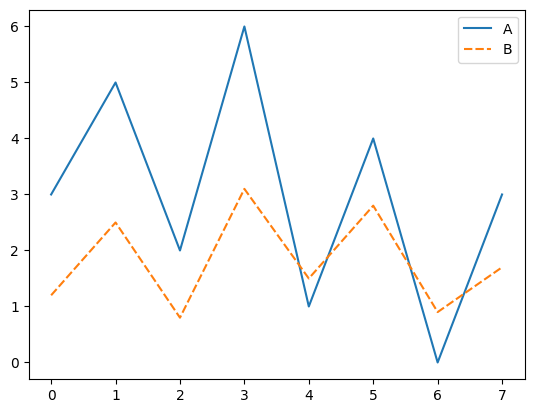

In [11]:
# Рисуем график
fig = sns.lineplot(data_simple).get_figure()
fig.savefig(r'examples/data/plots/test_plot.png')

In [12]:
# Инциализируем репортер, единственный аргумент - путь к итоговому отчету
path = r"examples/data/report.xlsx"
writer = ExcelReporter(path)

# Добавление датафреймов
writer.add_dataframe(
    data=data_simple,
    sheet_name="Sheet",
    table_name="with_index",
    index=True,
    row_offset=4,
    col_offset=2,
)
writer.add_dataframe(
    data=data_simple,
    sheet_name="Sheet",
    table_name="without_index",
    index=False,
    row_offset=4,
    col_offset=7,
)
writer.add_dataframe(
    data=data_with_multiIndex,
    sheet_name="Sheet",
    table_name="with_multiIndex",
    index=True,
    row_offset=15,
    col_offset=2,
)

# Добавление изображений
writer.add_image(
    img_path=r"examples/data/plots/test_plot.png",
    sheet_name="Sheet",
    row_offset=16.5,
    col_offset=7.5,
    scale=0.5,
)

# Сохранение результата
writer.save()

['Sheet']
